In [1]:
import sys
import os
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nustar_scripts.nu_pyxspec import scan_containers_ph_res, ph_res_param, Model, Fit, Plot, xspec,  AllModels
from nustar_scripts.nu_utils import set_mpl
from nustar_scripts.nu_class import NustarObservation, glob
from nustar_scripts.pulsar_init import Nu_path, ObsList_bright, plot_path, ObsAlias, analysis_path
%matplotlib inline 
set_mpl('Pastel2')

AllModels.lmod('relxill', '/Users/sdbykov/work/xray_pulsars/sj0243_nu/python_for_nustar/relxill_model/') #set path to relxill model


def pf_and_relative_var(observable):
    o_min = np.min(observable)
    o_max = np.max(observable)
    pf = (o_max-o_min)/(o_max+o_min)
    rel = o_max/o_min - 1 
    return pf, rel

def plot_results(ObsID, model = 'relxilllp-free-pars', plot_refl_flux = True):

    fig = plt.figure(figsize=(8, 5))
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)
    rows, cols = 3,  1
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax1 = plt.subplot2grid((rows, cols), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((rows, cols), (1, 0), rowspan=1, colspan=1, sharex = ax1)
    ax3 = plt.subplot2grid((rows, cols), (2, 0), rowspan=1, colspan=1, sharex = ax1)

    nu_obs = NustarObservation(ObsID, nu_path=Nu_path)
    #ph_ave_folder = nu_obs.products_path+'/spe_and_lc'
    ph_res_folder = nu_obs.products_path+'/phase_resolved/'
    os.chdir(ph_res_folder)


    df_ph_res = scan_containers_ph_res(model)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'refl_frac',  ax = ax2, plot = True)

    if plot_refl_flux:
        phases = np.arange(0, 10)
        phases = phases/10+0.05
        phases = np.concatenate((phases, phases+1))#np.tile(phases, 2)
        refl_flux, direct_flux = refl_fluxes[ObsID]
        pf_refl, R_refl = pf_and_relative_var(refl_flux)
        pf_direct, R_direct = pf_and_relative_var(direct_flux)
        
        print(f'Obs {ObsID}: reflected flux  PF = {pf_refl}; R = {R_refl}')
        print(f'Obs {ObsID}: direct flux  PF = {pf_direct}; R = {R_direct}')

        refl_flux = np.tile(refl_flux, 2)/refl_flux.mean()
        direct_flux = np.tile(direct_flux, 2)/direct_flux.mean()
        
        #refl_flux = np.tile(refl_flux, 2)/1e-9
        #direct_flux = np.tile(direct_flux, 2)/1e-9

        ax3.step(phases, refl_flux, ls = '-', color = 'C0', alpha = 1, lw = 3, where = 'mid', zorder = -1, label = 'Reflected')
        ax3.step(phases, direct_flux, ls = '-', color = 'C6', alpha = 1, lw = 3, where = 'mid', zorder = -1, label = 'Direct')
        #ax3.set_yscale('log')
        #ax3.grid(False)
        #ax3.set_ylabel('Flux \n 10$^{-9}$ erg cm$^{-2}$ s$^{-1}#$', fontsize = 12)
        ax3.set_ylabel('Flux/mean', fontsize = 12)
        ax3.legend(loc = 'lower right')



    fs = 12
    ax1.set_ylabel('Rate 4-79 keV, \n ${\\rm cts}\,{\\rm s}^{-1}$', fontsize = fs)
    ax2.set_ylabel(r'$f_{refl}$', fontsize = fs)
    ax3.set_xlabel('Phase', fontsize = fs)
    ax2.legend([])
    #ax4.set_title('')
    ax1.set_title(ObsAlias[ObsID], loc = 'center')



    efolds = glob('*.efold')
    _, phase_colors = nu_obs.plot_efolds_of_bins(prodpath='phase_resolved', efolds_files = efolds , ax_efold = ax1, fig = fig, save = False, legend=False, phase_zero_efold_file='phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')


    #fig.tight_layout()
    #plt.subplots_adjust(hspace = 0)
    plt.tight_layout()
    plt.show()
    return df_ph_res, fig




def calc_reflection_and_direct_flux(ObsID, model = 'relxilllp-free-pars', elo = '4.', ehi = '79.'):
    bin_numbers = 10
    fluxes_refl = []
    fluxes_direct = []
    for i, bin_number in enumerate(range(1,bin_numbers+1)):
        os.chdir(f"{analysis_path}out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        xspec.Xset.restore(f'./xspec/{model}/xcm/{ObsID}_bin{bin_number}_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"

        mo_loaded.relxilllp.refl_frac = "-"+str(refl_fract)
        mo_loaded.bbodyrad.norm = '0 -1'
        mo_loaded.phabs.nH = '0 -1'
        AllModels.calcFlux(f"{elo} {ehi}")
        fl = AllModels(1).flux[0]
        fluxes_refl.append(fl)


        xspec.AllData.clear()
        xspec.AllModels.clear()
        model = 'relxilllp'
        xspec.Xset.restore(f'./xspec/{model}/xcm/{ObsID}_bin{bin_number}_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"

        mo_loaded.relxilllp.refl_frac = '0 -1'
        mo_loaded.bbodyrad.norm = '0 -1'
        mo_loaded.phabs.nH = '0 -1'
        AllModels.calcFlux(f"{elo} {ehi}")
        fl = AllModels(1).flux[0]
        fluxes_direct.append(fl)


    fluxes_refl = np.array(fluxes_refl)
    fluxes_direct = np.array(fluxes_direct)
    pf_refl, R_refl = pf_and_relative_var(fluxes_refl)
    pf_direct, R_direct = pf_and_relative_var(fluxes_direct)

    print(f'Obs {ObsID}: reflected emission  PF = {pf_refl}; R = {R_refl}')
    print(f'Obs {ObsID}: direct emission  PF = {pf_direct}; R = {R_direct}')
    return fluxes_refl,  fluxes_direct


In [3]:
refl_fluxes = {}
for ObsID in [ObsList_bright[1],ObsList_bright[2], ObsList_bright[3]]:
    tmp = calc_reflection_and_direct_flux(ObsID, ehi = '50.')
    refl_fluxes[ObsID] = tmp


Obs 90302319004: reflected emission  PF = 0.287704131335785; R = 0.8078219851964696
Obs 90302319004: direct emission  PF = 0.5384733271747977; R = 2.3334440190794266
Obs 90302319006: reflected emission  PF = 0.44257866931244516; R = 1.5879502449845027
Obs 90302319006: direct emission  PF = 0.6585516455484433; R = 3.8574011967708914
Obs 90302319008: reflected emission  PF = 0.1258564198961109; R = 0.2879536560370397
Obs 90302319008: direct emission  PF = 0.3491441082538401; R = 1.0728768462620284


###
Observation 90302319004 loaded successfully
Obs 90302319004: reflected flux  PF = 0.287704131335785; R = 0.8078219851964696
Obs 90302319004: direct flux  PF = 0.5384733271747977; R = 2.3334440190794266


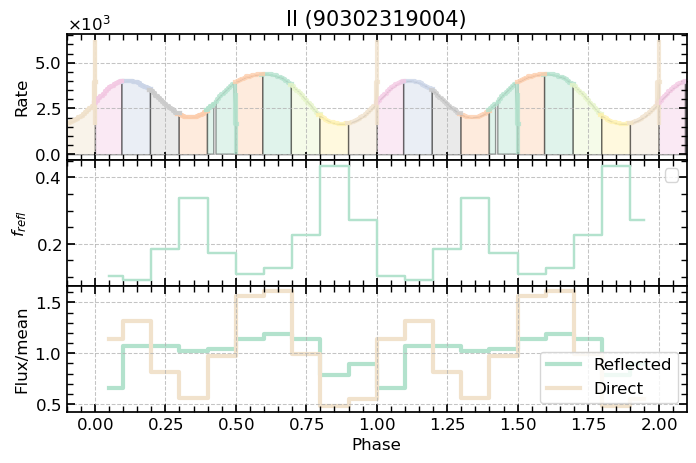

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319006 loaded successfully
Obs 90302319006: reflected flux  PF = 0.44257866931244516; R = 1.5879502449845027
Obs 90302319006: direct flux  PF = 0.6585516455484433; R = 3.8574011967708914


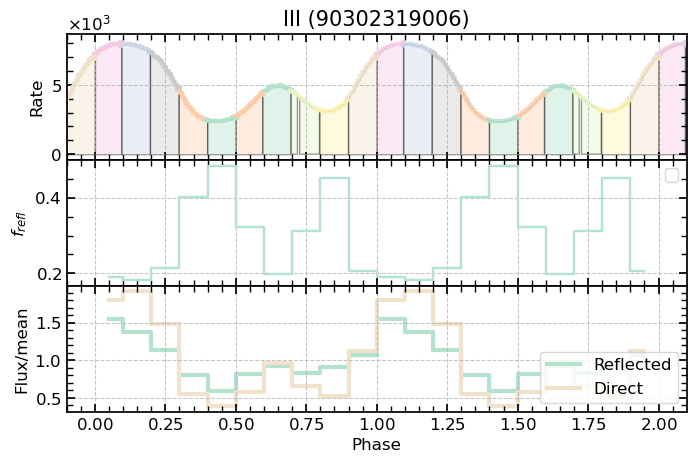

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319008 loaded successfully
Obs 90302319008: reflected flux  PF = 0.1258564198961109; R = 0.2879536560370397
Obs 90302319008: direct flux  PF = 0.3491441082538401; R = 1.0728768462620284


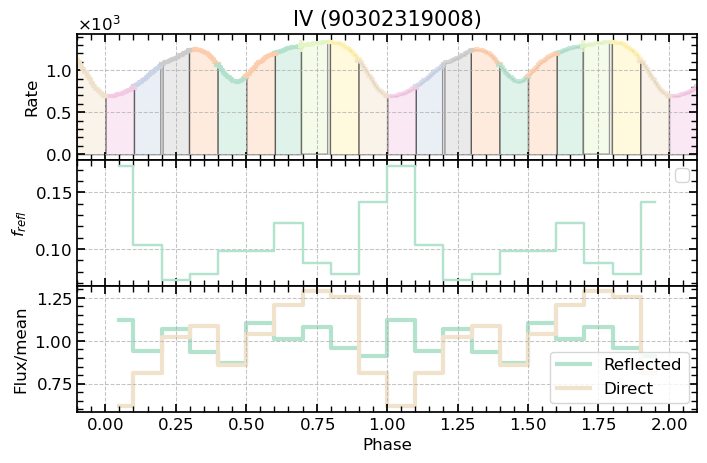

<Figure size 1000x1000 with 0 Axes>

In [4]:
df1, fig1 = plot_results(ObsList_bright[1]);

df2, fig2 = plot_results(ObsList_bright[2]);

df3, fig3 = plot_results(ObsList_bright[3]);



In [9]:
print(df1.loc[pd.IndexSlice['relxilllp','Rin', 0.05:0.2]])
print(df2.loc[pd.IndexSlice['relxilllp','Rin', 0.05:0.2]])
print(df3.loc[pd.IndexSlice['relxilllp','Rin', 0.05:0.2]])

                     error_l  error_u  frozen      val
comp      par phase                                   
relxilllp Rin 0.05       0.0      0.0     1.0  65.6416
              0.15       0.0      0.0     1.0  65.6416
                     error_l  error_u  frozen      val
comp      par phase                                   
relxilllp Rin 0.05       0.0      0.0     1.0  52.6286
              0.15       0.0      0.0     1.0  52.6286
                     error_l  error_u  frozen      val
comp      par phase                                   
relxilllp Rin 0.05       0.0      0.0     1.0  51.0693
              0.15       0.0      0.0     1.0  51.0693


In [5]:
print(df1.loc[pd.IndexSlice['relxilllp','logxi', 0.05:0.2]])
print(df2.loc[pd.IndexSlice['relxilllp','logxi', 0.05:0.2]])
print(df3.loc[pd.IndexSlice['relxilllp','logxi', 0.05:0.2]])

                       error_l  error_u  frozen       val
comp      par   phase                                    
relxilllp logxi 0.05       0.0      0.0     0.0  3.351764
                0.15       0.0      0.0     0.0  3.295138
                       error_l  error_u  frozen       val
comp      par   phase                                    
relxilllp logxi 0.05       0.0      0.0     0.0  3.845816
                0.15       0.0      0.0     0.0  3.877093
                       error_l  error_u  frozen       val
comp      par   phase                                    
relxilllp logxi 0.05       0.0      0.0     0.0  3.412146
                0.15       0.0      0.0     0.0  3.359113


In [6]:
df1.loc[pd.IndexSlice[:,:, 0.5:0.6]]

error_l  error_u  frozen          val
comp      par         phase                                       
bbodyrad  kT          0.55       0.0      0.0     0.0     1.263381
          norm        0.55       0.0      0.0     0.0  1369.421028
phabs     nH          0.55       0.0      0.0     1.0     0.800000
relxilllp Afe         0.55       0.0      0.0     1.0     5.000000
          Ecut        0.55       0.0      0.0     0.0    24.902739
          Incl        0.55       0.0      0.0     1.0    17.648700
          Rin         0.55       0.0      0.0     1.0    65.641600
          a           0.55       0.0      0.0     1.0     0.000000
          fixReflFrac 0.55       0.0      0.0     1.0     0.000000
          gamma       0.55       0.0      0.0     0.0     1.330970
          h           0.55       0.0      0.0     1.0     5.000000
          logxi       0.55       0.0      0.0     0.0     3.522971
          norm        0.55       0.0      0.0     0.0     0.782512
          refl_frac   0.55       0.0      0.0     0.0     0.107276
          z           0.55       0.0      0.0     1.0     0.000000

In [7]:

def plot_results_all(ObsID, model = 'relxilllp-free-pars', plot_refl_flux = True):

    fig = plt.figure(figsize=(6, 8))
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)
    rows, cols = 6,  1
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax1 = plt.subplot2grid((rows, cols), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((rows, cols), (1, 0), rowspan=1, colspan=1, sharex = ax1)
    ax3 = plt.subplot2grid((rows, cols), (2, 0), rowspan=1, colspan=1, sharex = ax1)
    ax4 = plt.subplot2grid((rows, cols), (3, 0), rowspan=1, colspan=1, sharex = ax1)
    ax5 = plt.subplot2grid((rows, cols), (4, 0), rowspan=1, colspan=1, sharex = ax1)
    ax6 = plt.subplot2grid((rows, cols), (5, 0), rowspan=1, colspan=1, sharex = ax1)

    nu_obs = NustarObservation(ObsID, nu_path=Nu_path)
    #ph_ave_folder = nu_obs.products_path+'/spe_and_lc'
    ph_res_folder = nu_obs.products_path+'/phase_resolved/'
    os.chdir(ph_res_folder)


    df_ph_res = scan_containers_ph_res(model)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'refl_frac',  ax = ax2, plot = True)

    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'Ecut',  ax = ax4, plot = True)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'gamma',  ax = ax5, plot = True)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'norm',  ax = ax6, plot = True)




    
    if plot_refl_flux:
        phases = np.arange(0, 10)
        phases = phases/10+0.05
        phases = np.concatenate((phases, phases+1))#np.tile(phases, 2)
        refl_flux, direct_flux = refl_fluxes[ObsID]
        pf_refl, R_refl = pf_and_relative_var(refl_flux)
        pf_direct, R_direct = pf_and_relative_var(direct_flux)
        
        print(f'Obs {ObsID}: reflected flux  PF = {pf_refl}; R = {R_refl}')
        print(f'Obs {ObsID}: direct flux  PF = {pf_direct}; R = {R_direct}')

        refl_flux = np.tile(refl_flux, 2)/refl_flux.mean()
        direct_flux = np.tile(direct_flux, 2)/direct_flux.mean()
        
        #refl_flux = np.tile(refl_flux, 2)/1e-9
        #direct_flux = np.tile(direct_flux, 2)/1e-9

        ax3.step(phases, refl_flux, ls = '-', color = 'C0', alpha = 1, lw = 3, where = 'mid', zorder = -1, label = 'Reflected')
        ax3.step(phases, direct_flux, ls = '-', color = 'C6', alpha = 1, lw = 3, where = 'mid', zorder = -1, label = 'Direct')
        #ax3.set_yscale('log')
        #ax3.grid(False)
        #ax3.set_ylabel('Flux \n 10$^{-9}$ erg cm$^{-2}$ s$^{-1}#$', fontsize = 12)
        ax3.set_ylabel('Flux/mean', fontsize = 12)
        ax3.legend(loc = 'lower right')



    fs = 12
    ax1.set_ylabel('Rate 4-79 keV, \n ${\\rm cts}\,{\\rm s}^{-1}$', fontsize = fs)
    ax2.set_ylabel(r'$f_{refl}$', fontsize = fs)
    ax4.set_ylabel(r'$E_{\rm cut}$, keV', fontsize = fs)
    ax5.set_ylabel(r'$\Gamma$', fontsize = fs)
    ax6.set_ylabel(r'norm', fontsize = fs)
    ax3.set_xlabel('Phase', fontsize = fs)
    ax2.legend([])
    #ax4.set_title('')
    ax1.set_title(ObsAlias[ObsID], loc = 'center')



    efolds = glob('*.efold')
    _, phase_colors = nu_obs.plot_efolds_of_bins(prodpath='phase_resolved', efolds_files = efolds , ax_efold = ax1, fig = fig, save = False, legend=False, phase_zero_efold_file='phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')


    #fig.tight_layout()
    #plt.subplots_adjust(hspace = 0)
    plt.tight_layout()
    plt.show()
    return df_ph_res, fig




###
Observation 90302319004 loaded successfully
Obs 90302319004: reflected flux  PF = 0.287704131335785; R = 0.8078219851964696
Obs 90302319004: direct flux  PF = 0.5384733271747977; R = 2.3334440190794266


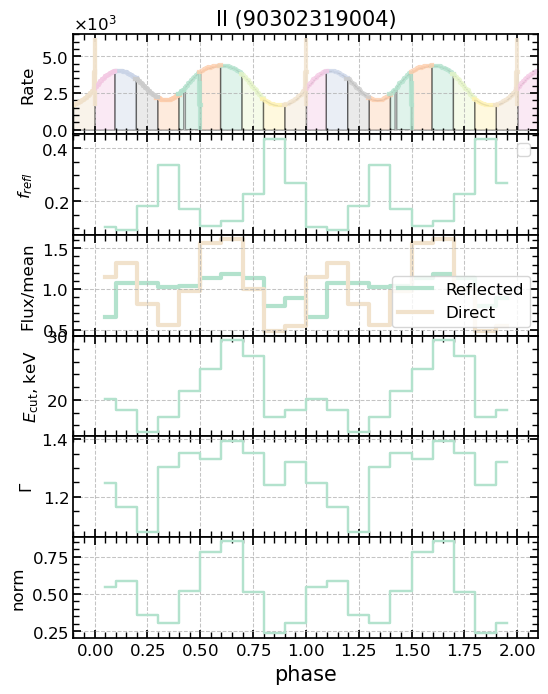

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319006 loaded successfully
Obs 90302319006: reflected flux  PF = 0.44257866931244516; R = 1.5879502449845027
Obs 90302319006: direct flux  PF = 0.6585516455484433; R = 3.8574011967708914


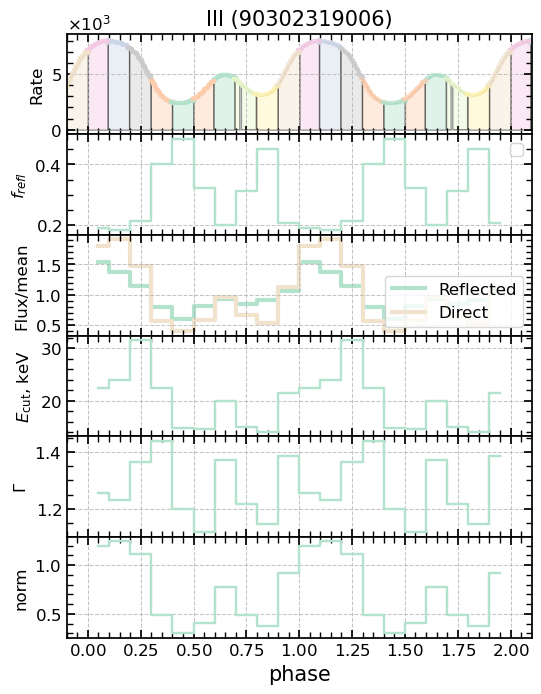

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319008 loaded successfully
Obs 90302319008: reflected flux  PF = 0.1258564198961109; R = 0.2879536560370397
Obs 90302319008: direct flux  PF = 0.3491441082538401; R = 1.0728768462620284


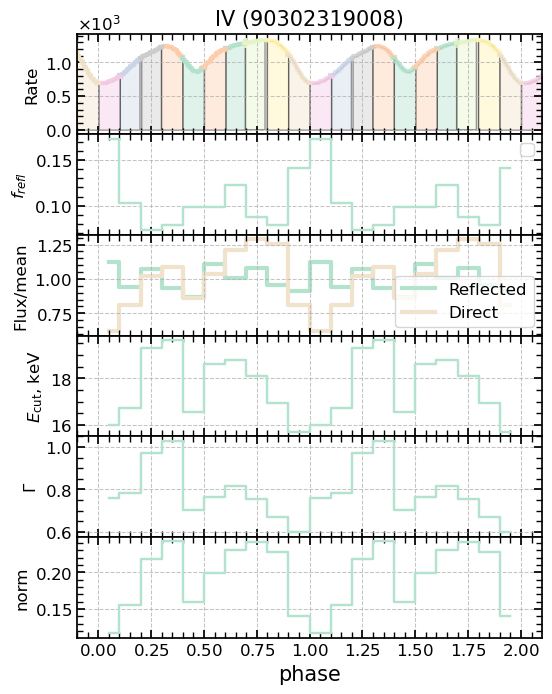

<Figure size 1000x1000 with 0 Axes>

In [8]:
df1, fig1 = plot_results_all(ObsList_bright[1]);

df2, fig2 = plot_results_all(ObsList_bright[2]);

df3, fig3 = plot_results_all(ObsList_bright[3]);


